In [1]:
# !conda install -c conda-forge xgboost=1.3.3

In [2]:
# !conda install -c conda-forge lightgbm=3.1.1 
# !conda install -c conda-forge missingno=0.4.2

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
data_dir = 'C:\\Users\\Soonju\\Desktop\\Aiffel\\Kaggle\\Housing_Price\\data'
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음) 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음) 근처 15가구의 부지, 평방 피트

In [6]:
data = pd.read_csv(train_data_path) # (15035, 21)
sub = pd.read_csv(sub_data_path) # (6468, 20)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [7]:
# train = data의 price를 지워야 20 column이 되고, test=sub와 묶어 하나의 데이터셋을 만들 수 있음.
data['price']
y = data['price']
print(data.columns)
del data['price']
print(data.columns)
print(sub.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
train_len = len(data)   # 다시 분리할지도 모르니 인덱스로 하나 정해두는 변수
print(train_len) # 15035
data = pd.concat((data, sub), axis=0) # 합침
print('all data dim : {}'.format(data.shape)) # all data dim : (21503, 20)

15035
all data dim : (21503, 20)


In [9]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

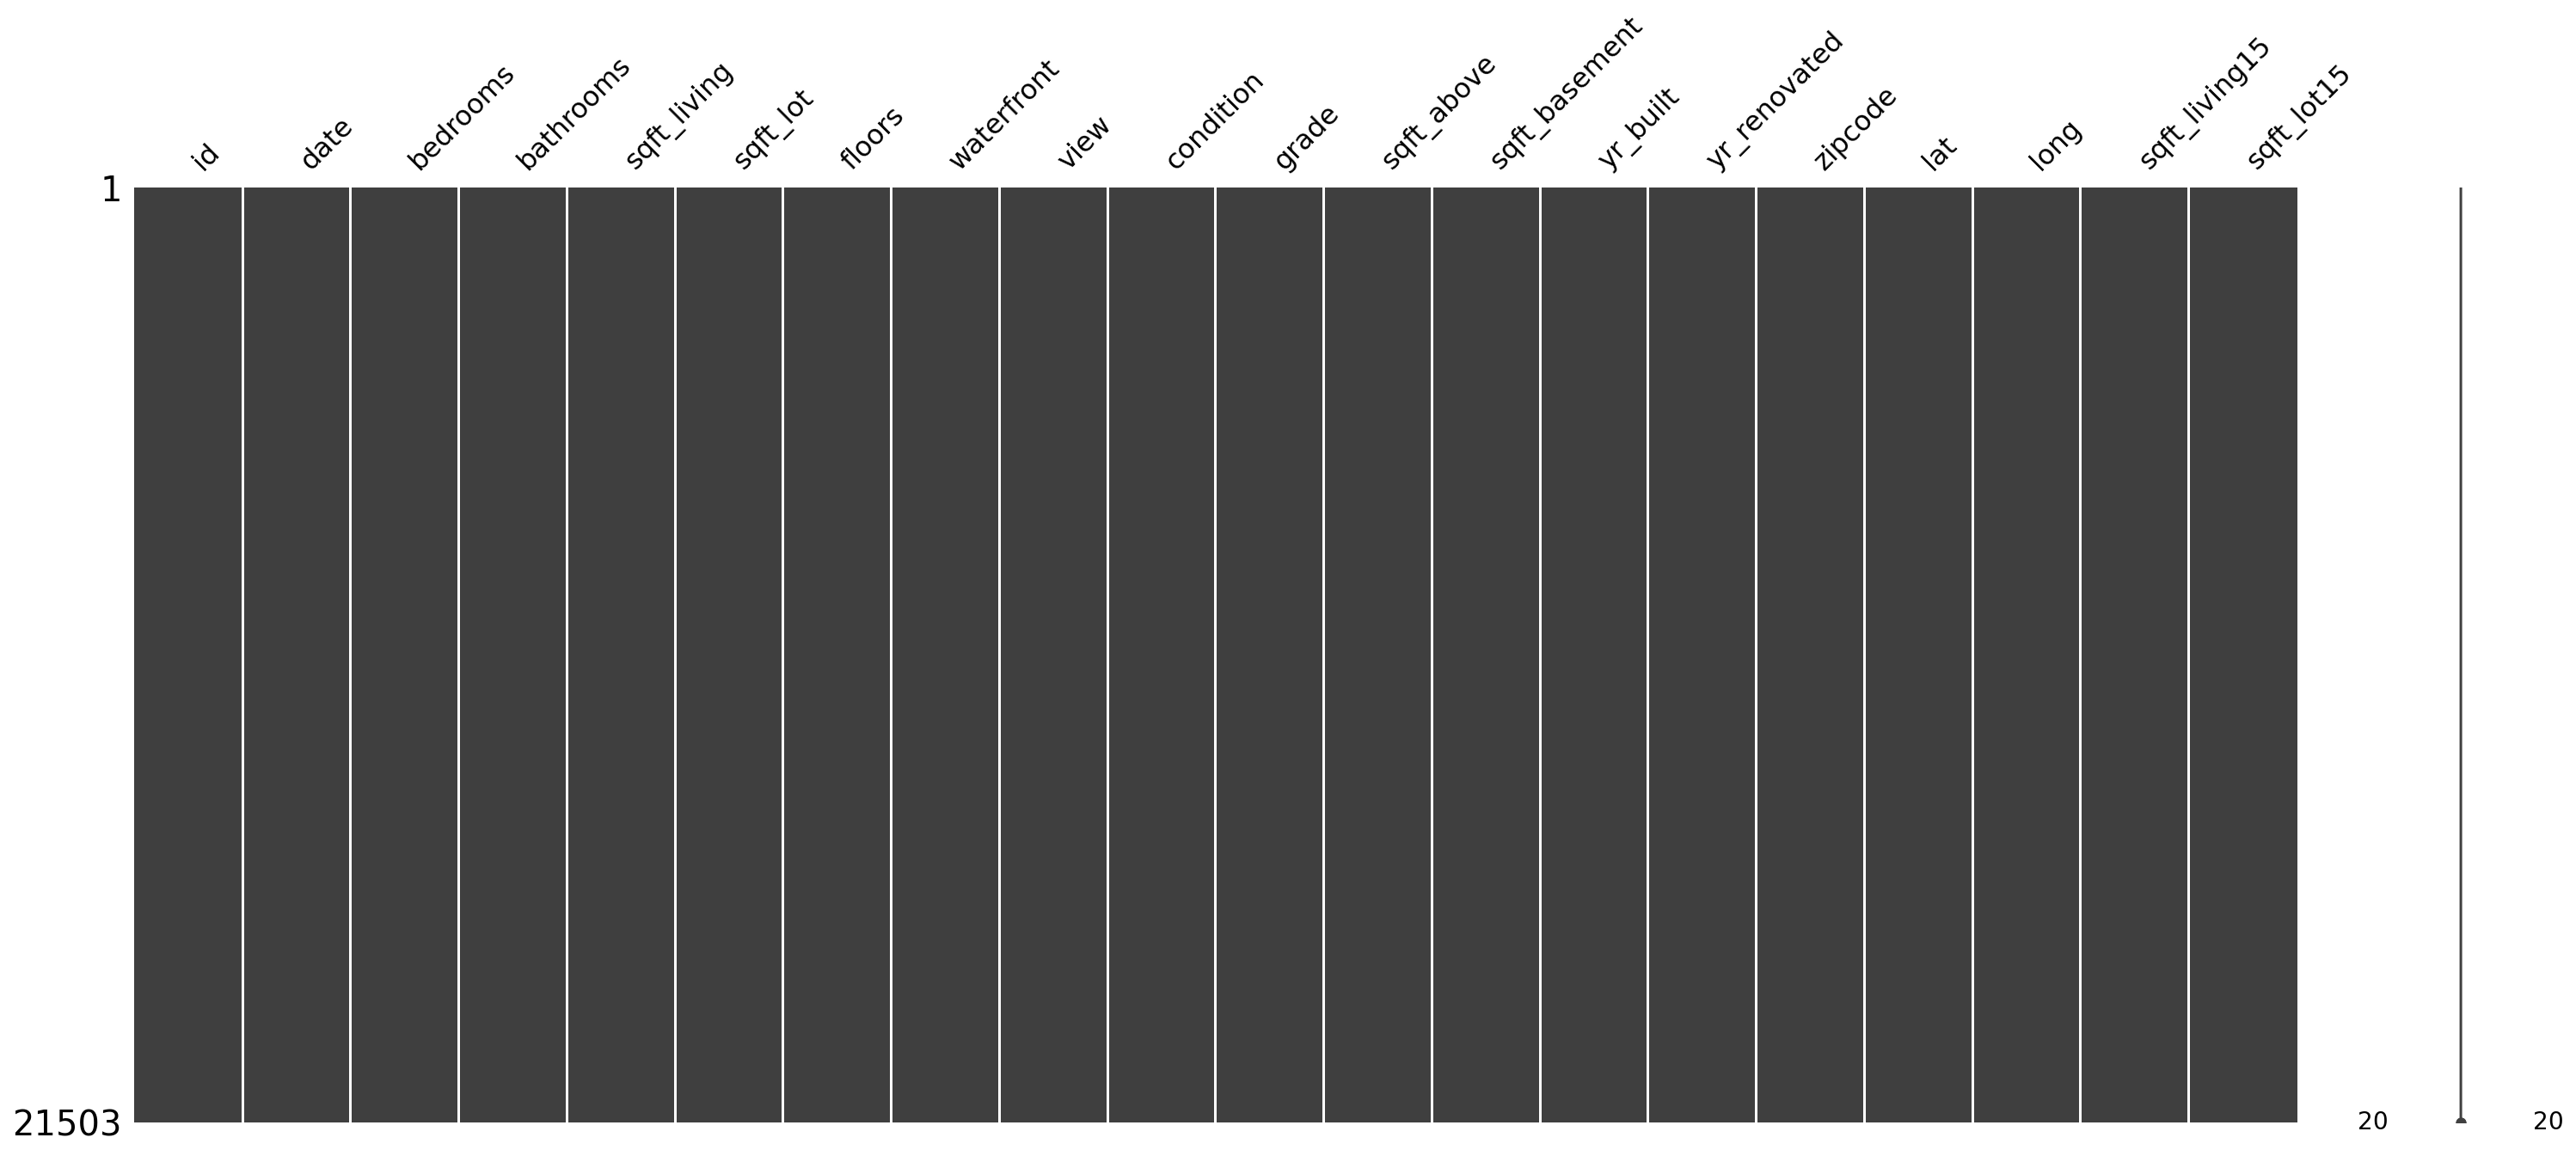

In [10]:
msno.matrix(data)

In [11]:
# 1. id 컬럼이 결측치인지 확인합니다.
print(data['id'].tail())
null_check = pd.isnull(data['id'])
print(null_check)
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

# 3. 결측치인 데이터의 개수를 셉니다.
# print(f'id: {len(null_data.values)}')

6463    21498
6464    21499
6465    21500
6466    21501
6467    21502
Name: id, dtype: int64
0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


Series([], Name: id, dtype: int64)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [12]:
for c in data.columns:  # data의 columns들을 x인자로 다 돌릴꺼고, 그 x들은 c라고 부를께
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))
                # 컬럼명,길이(데이터에서.찾아[결측값으로(컬럼명에서,값)true].갯수

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [13]:
# 혹시 쓸 줄 모르니, sub_id라는 변수명에 저장해놓고 지우기
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)
# 20141013T000000 -> 201410

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

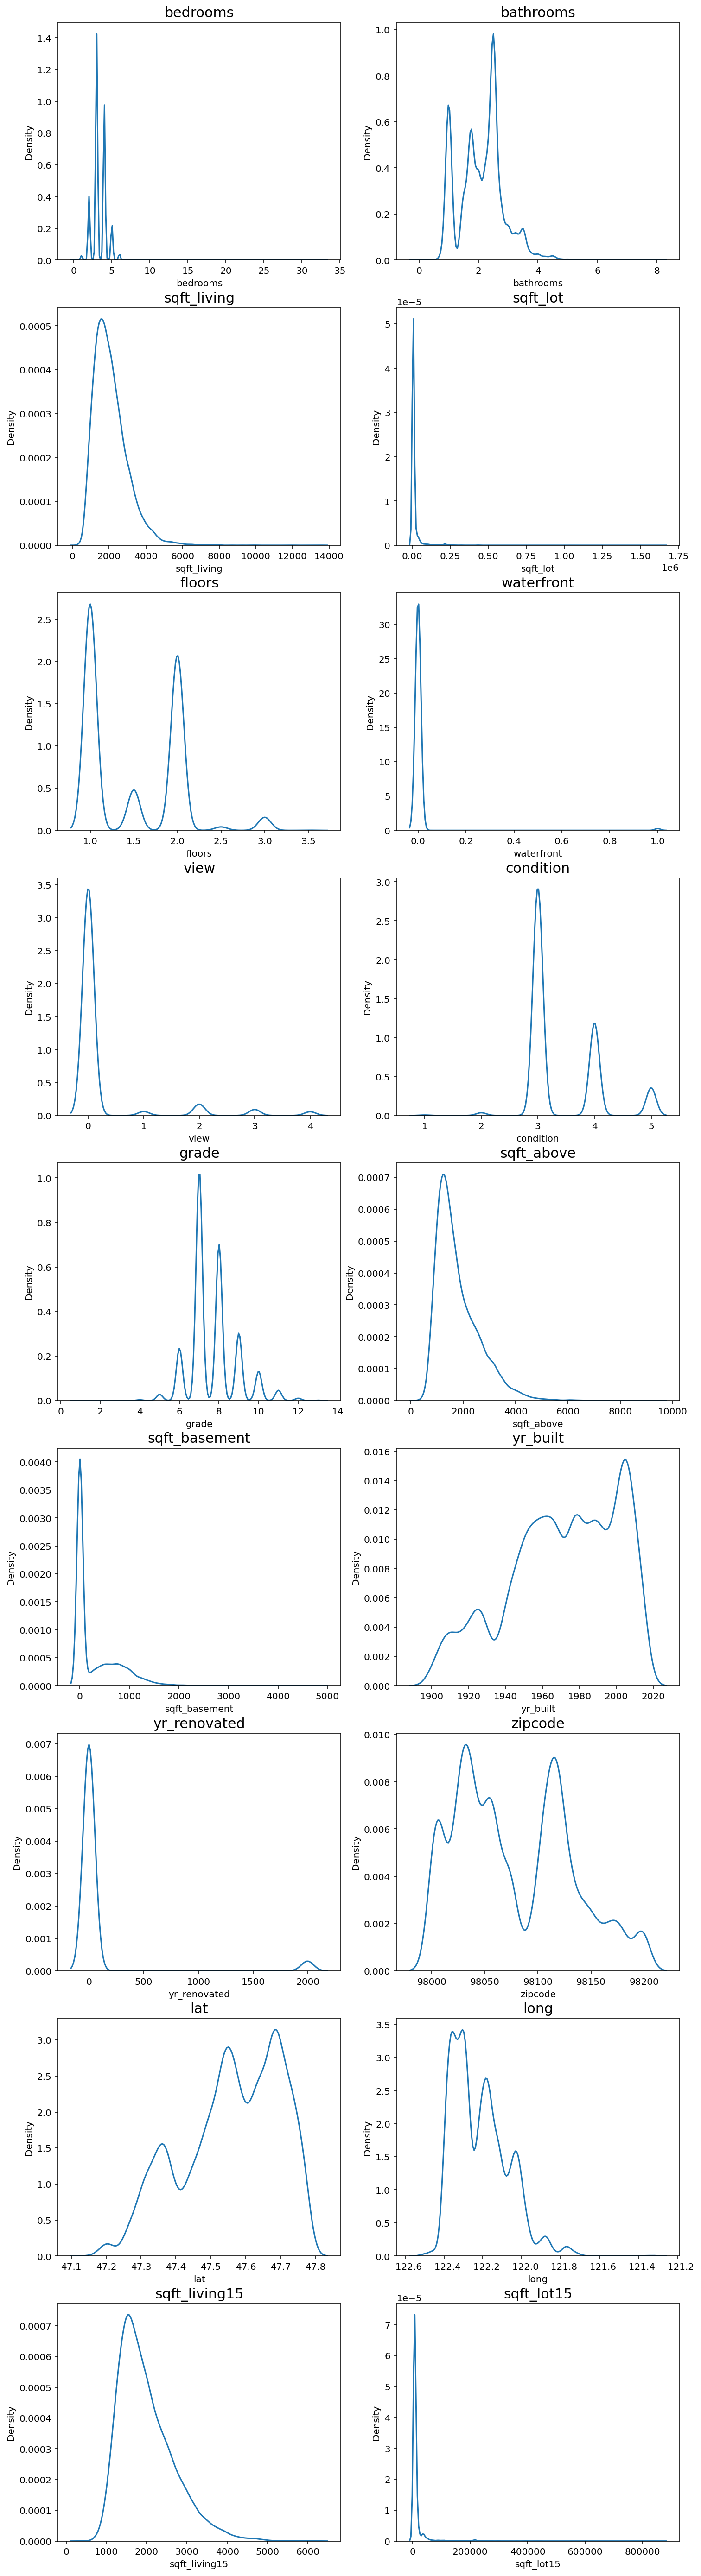

In [14]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))  # 총 20칼럼중, id빼서 19.
# id 변수는 제외하고 분포를 확인합니다. >> date 변수 제외하고 확인 18
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

---
(보충설명) 치우침을 보완하기 : loss 함수 이용해 정규분포 종모양에 가깝게 만들기.

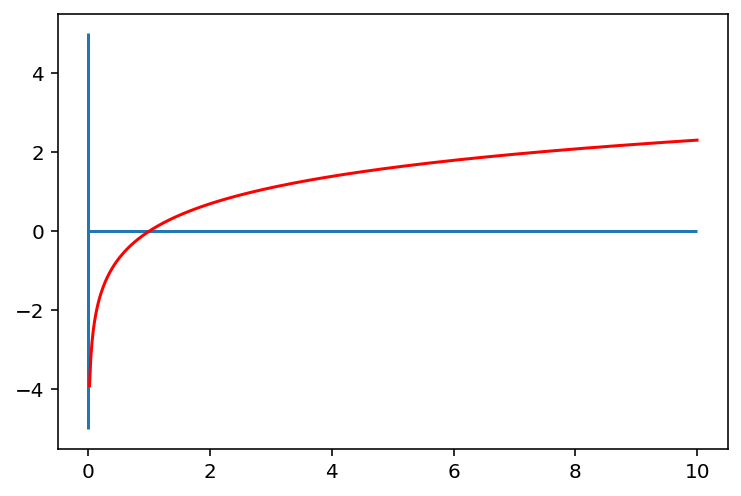

In [15]:
# 로그함수
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

위와 같은 로그 함수의 특징은 다음과 같습니다.

0 < x < 10<x<1 범위에서는 기울기가 매우 가파릅니다. 즉, xx의 구간은 (0, 1)(0,1)로 매우 짧은 반면, yy의 구간은 (-\infty, 0)(−∞,0)으로 매우 큽니다.
따라서 0에 가깝게 모여있는 값들이 xx로 입력되면, 그 함수값인 yy 값들은 매우 큰 범위로 벌어지게 됩니다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가집니다.
반면, xx값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아집니다. 이는 곧 큰 xx값들에 대해서는 yy값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 xx를 비교적 작은 yy값의 구간 내에 모이게 하는 특징을 가집니다.
위와 같은 특성 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼질 수 있는 것이죠.

왜 한쪽으로 치우친 분포를 로그 변환을 취하게 되면 정규분포 모양으로 고르게 분포하게 될 수 있는지 이해가 되시나요?

그렇다면 우리가 맞추어야 할 타겟인 집의 가격, 즉 data[price]의 분포를 로그 변환했을 때 결과를 유추해봅시다.
원래 price의 분포는 다음과 같습니다.

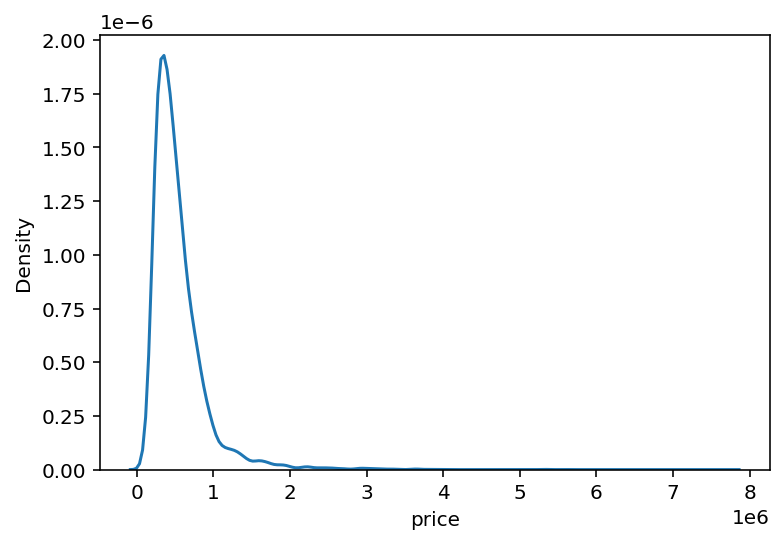

In [16]:
sns.kdeplot(y)
plt.show()

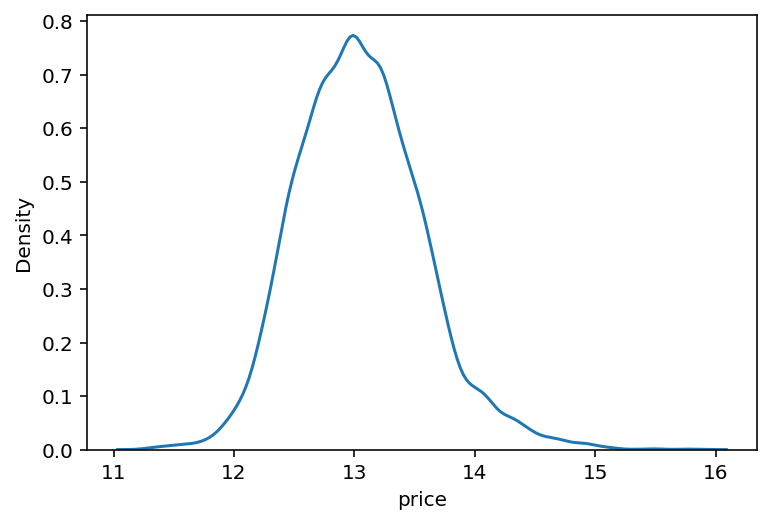

In [17]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

---


위 그래프 중에서는 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보이는군요..<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [18]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

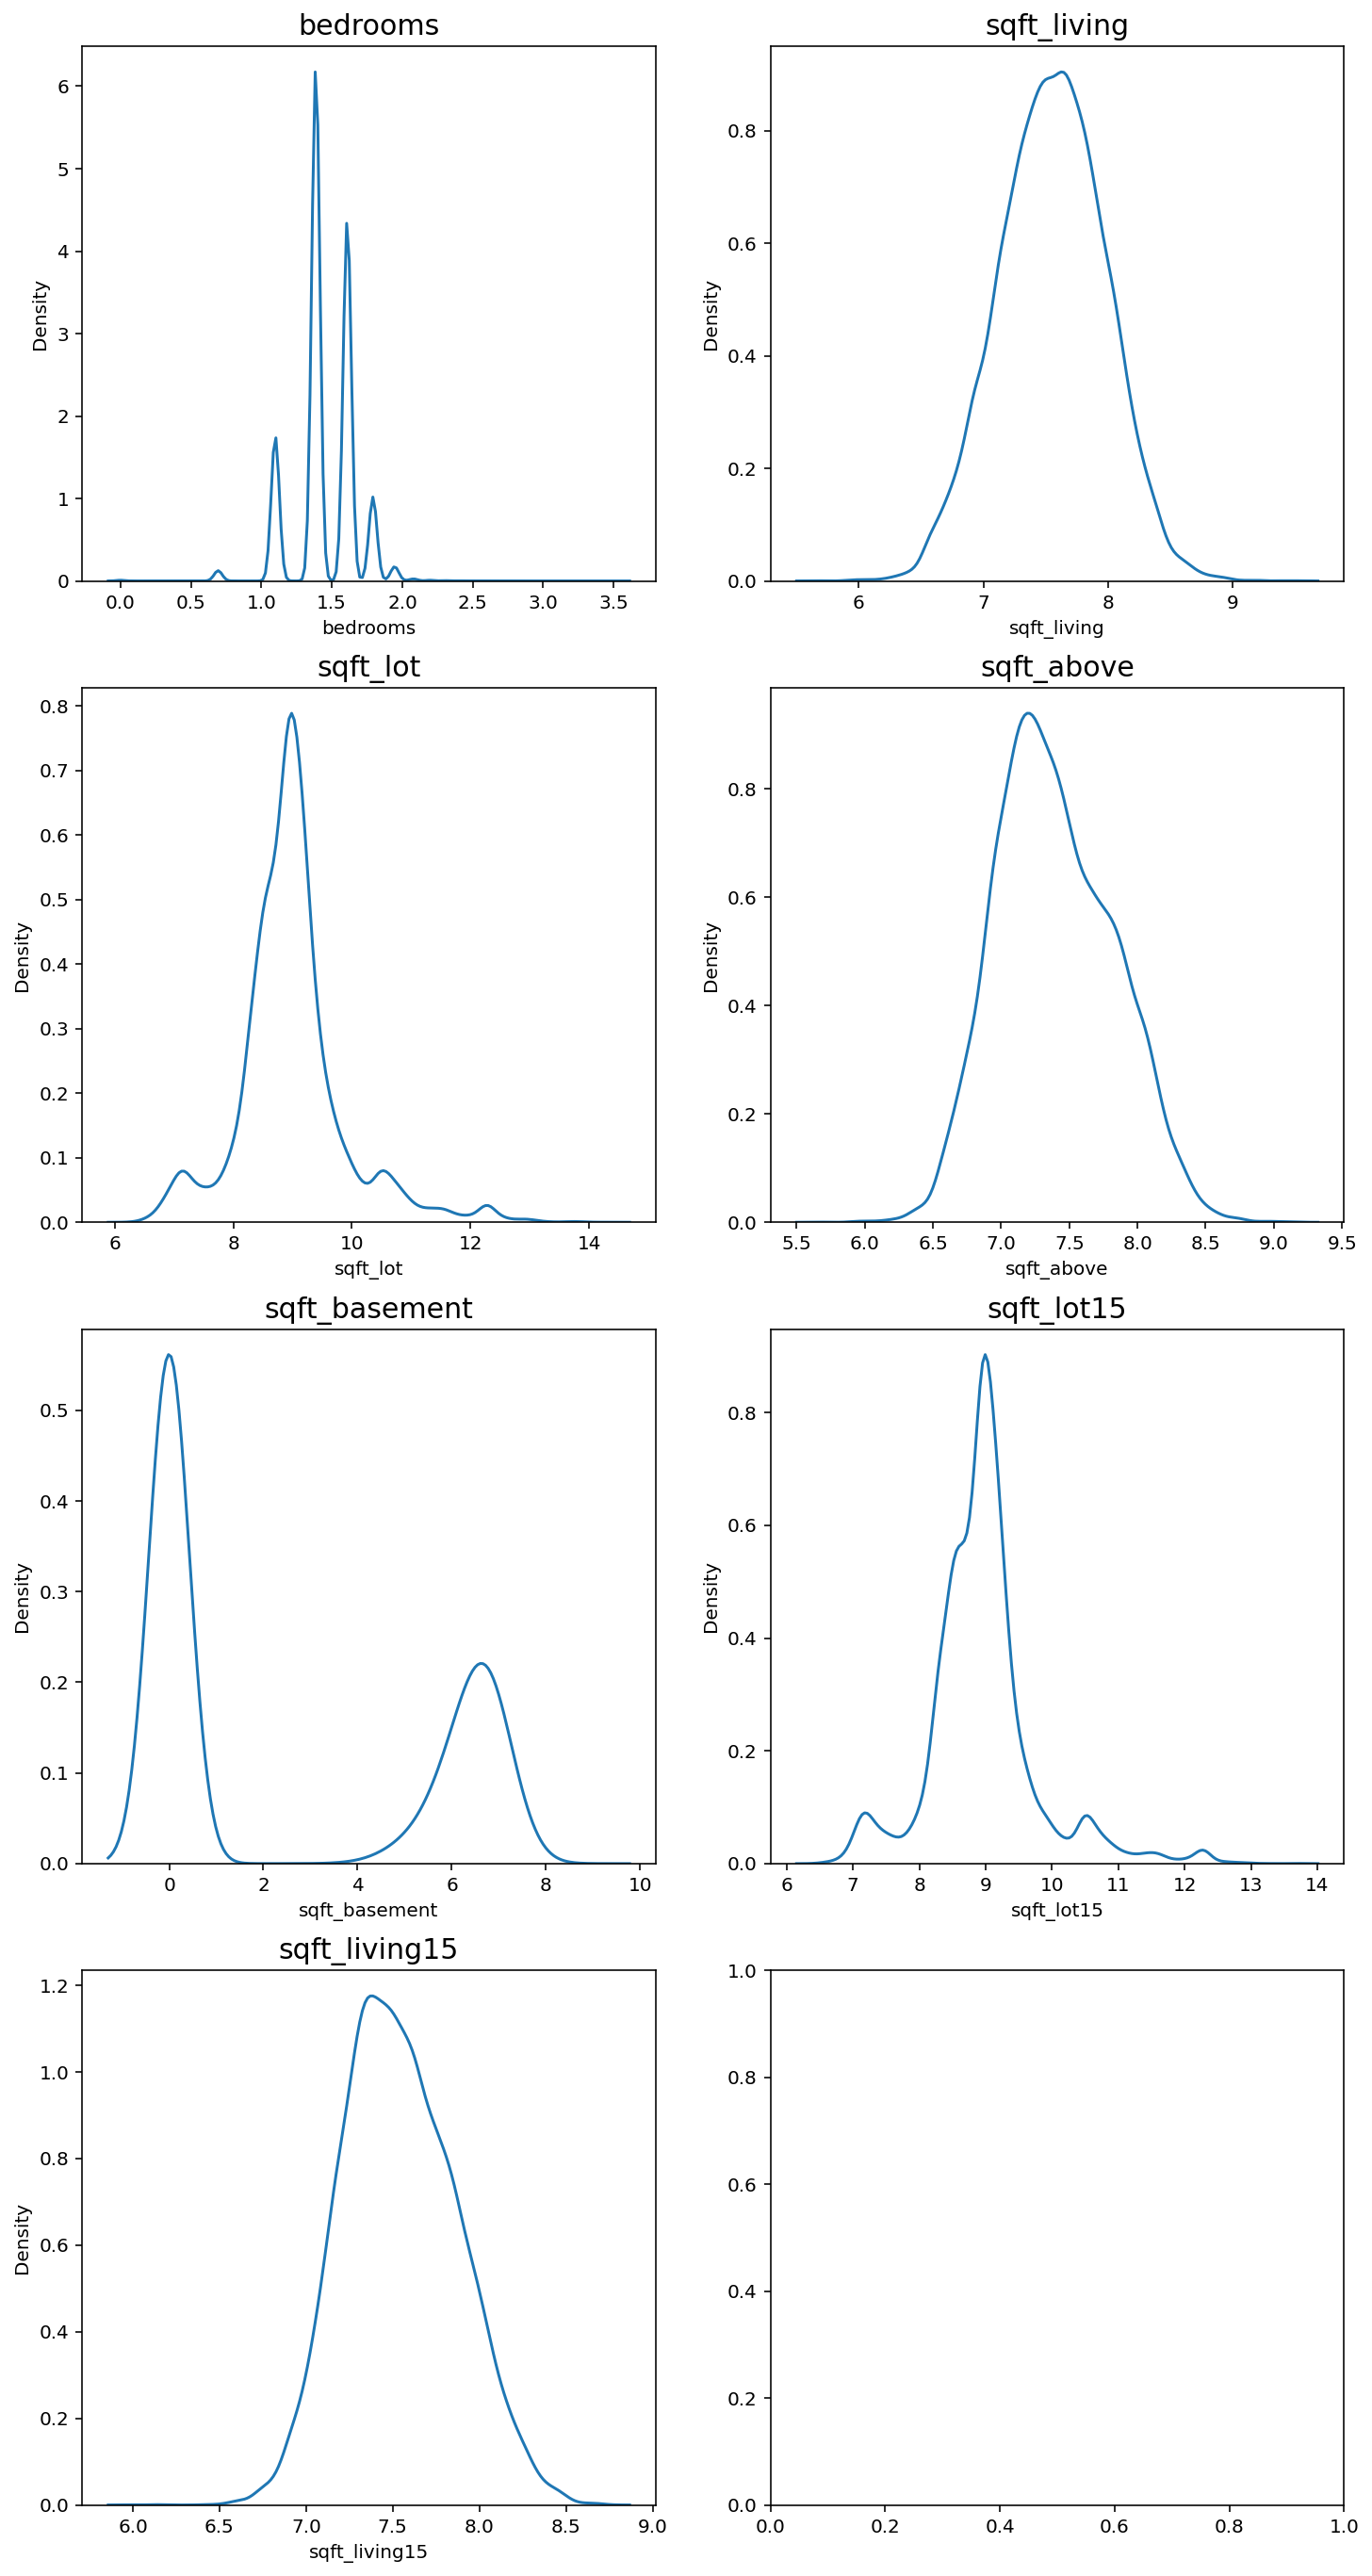

In [19]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))  # 정규분포로 만든 8개컬럼만 

count = 0
columns = data.columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1
        if count == 7:
            break

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [20]:
x = data.iloc[:train_len, :]
sub = data.iloc[train_len:, :]

print(x.shape, sub.shape)
# train data dim : (15035, 21) (price, id del) / sub data dim : (6468, 20) (id del)
# train_len : 15035

(15035, 19) (6468, 19)


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [21]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

randome_state=2020
gboost = GradientBoostingRegressor(random_state=randome_state)
xgboost = xgb.XGBRegressor(random_state=randome_state)
lightgbm = lgb.LGBMRegressor(random_state=randome_state)
rdforest = RandomForestRegressor(random_state=randome_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},{'model':rdforest, 'name':'rdforest'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.  
https://wooono.tistory.com/105 : 교차검증 설명

In [22]:
# gboost 하나만 해봤을때
kfold = KFold(n_splits=5).get_n_splits(x.values) # get_n_splits : X 데이터셋에 가장 적절한 fold수를 찾아줌
scores = cross_val_score(gboost , X=x.values, y=y,cv=kfold) #(모델명, X값,y값, fold수)
print('교차 검증별 정확도:',np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))
scores1 = cross_val_score(xgboost , X=x.values, y=y,cv=kfold)
print('교차 검증별 정확도:',np.round(scores1, 4))
print('평균 검증 정확도:', np.round(np.mean(scores1), 4))
scores2 = cross_val_score(lightgbm , X=x.values, y=y,cv=kfold)
print('교차 검증별 정확도:',np.round(scores2, 4))
print('평균 검증 정확도:', np.round(np.mean(scores2), 4))



교차 검증별 정확도: [0.8797 0.8626 0.8556 0.8303 0.8761]
평균 검증 정확도: 0.8609
교차 검증별 정확도: [0.8772 0.8903 0.887  0.8814 0.8943]
평균 검증 정확도: 0.886
교차 검증별 정확도: [0.8764 0.8691 0.8838 0.876  0.9039]
평균 검증 정확도: 0.8819


In [23]:
# 모든 모델 다했을때
from sklearn.metrics import mean_squared_error
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        rmse = np.mean(np.sqrt(-cross_val_score(m['model'],  X=x.values, y=np.expm1(y), scoring = "neg_mean_squared_error", cv = kfold)))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        print("RMSE : {:.4f}".format(rmse))

In [24]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8609
RMSE : nan
Model: XGBoost, CV score:0.8860
RMSE : nan
Model: LightGBM, CV score:0.8819
RMSE : nan
Model: rdforest, CV score:0.8680
RMSE : nan


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [25]:
def AveragingBlending(models, x, y, sub_x): # sub_x : test시킬 데이터셋
    for m in models :                 # 3개의 모델 각각에 학습시키고
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([    # 각 모델의 prediction을 stack 쌓아서
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)   # prediction의 평균값을 최종으로 리턴

In [26]:
y_pred = AveragingBlending(models, x, y, sub) 
print(len(y_pred))
y_pred

6468


array([ 517551.61978684,  447382.47204463, 1344610.18432082, ...,
        455090.03602759,  338594.72264457,  428540.54738762])

In [27]:
# 견본 submission의 shape 보기 
data_dir = 'C:\\Users\\Soonju\\Desktop\\Aiffel\\Kaggle\\Housing_Price\\data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [28]:
# 제출양식인 id, price 에 맞게 나의 result도 df로 만들기

result = pd.DataFrame({'id' : sub_id,'price' : y_pred})
result.head()

,id,price
0,15035,5.175516e+05
1,15036,4.473825e+05
2,15037,1.344610e+06
3,15038,3.233498e+05
4,15039,3.121969e+05


In [29]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

C:\Users\Soonju\Desktop\Aiffel\Kaggle\Housing_Price\data\submission.csv


# (심화) 모델 발전시키기

In [30]:
train = pd.read_csv(train_data_path) # (15035, 21)
test = pd.read_csv(sub_data_path) # (6468, 20)
print(train.shape,test.shape)

(15035, 21) (6468, 20)


In [31]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
y = train['price']
del train['price']
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [32]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [33]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

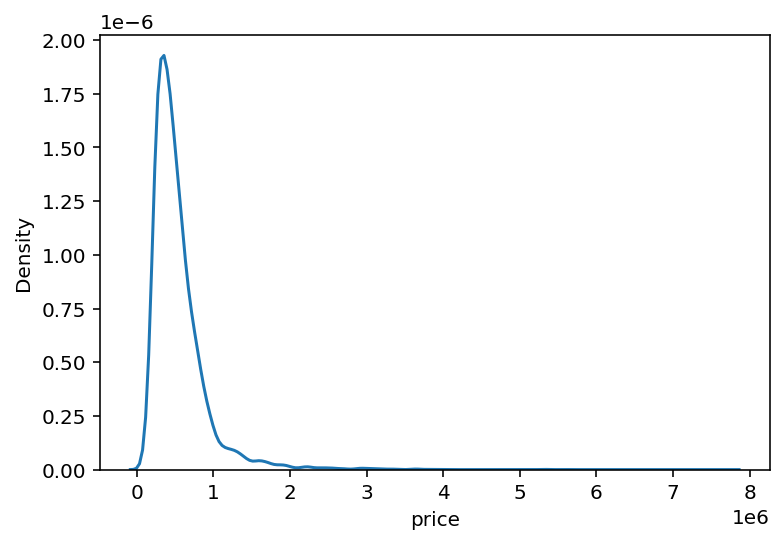

In [34]:
sns.kdeplot(y)

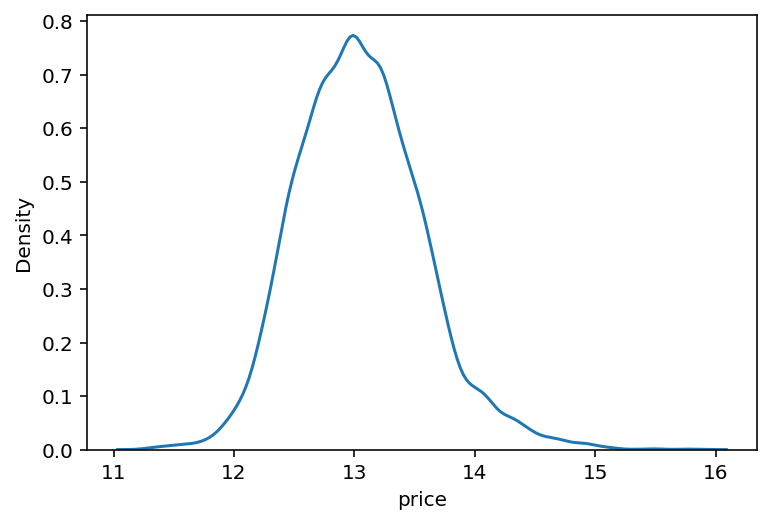

In [35]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int32  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [38]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020      

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [39]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 112334.52117822798,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125367.2973747959}

In [60]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

GridSearchCV : 최적의 hyperparameter를 찾기 위해 사용.
    - sklearn.model_selection.GridSearchCV
    - (estimator, param_grid, scoring, n_jobs, refit, cv, verbose, pre_dispatch)
    - estimator : 학습시킬 모델종류
    - param_grid: 실행해볼 hyperparameter목록, dict객체로 줄 것
    - cv : 교차분석에 사용할 fold 갯수, 기본값 = 5
    - verbose : 기본값 0, 간단한 메세지 1, 하이퍼 파라미터별 메세지 2
    - n_jobs : 기본값 None, -1로 지정하면 모든 cpu를 자동사용. 속도 빨라짐.

In [61]:
from sklearn.model_selection import GridSearchCV

random_state = 2020
param_grid = {'n_estimator': [50, 100],'max_depth':[1, 10],}
model = lgb.LGBMRegressor(randome_state=randome_state)
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(randome_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimator': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [62]:
grid_model.cv_results_

{'mean_fit_time': array([0.06759849, 0.06439943, 0.230827  , 0.23963871]),
 'std_fit_time': array([0.00467312, 0.00101939, 0.01646626, 0.01335182]),
 'mean_score_time': array([0.00500031, 0.00519962, 0.01639957, 0.01500092]),
 'std_score_time': array([1.53331139e-06, 4.01044753e-04, 4.89338470e-04, 1.41353795e-03]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimator': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimator': 50},
  {'max_depth': 1, 'n_estimator': 100},
  {'max_depth': 10, 'n_estimator': 50},
  {'max_depth': 10, 'n_estimator': 100}],
 'split0_test_score': array([-0.05555652, -0.05555652, -0.02665428, -0.02665428]),
 'split1_test_score': array([-0.057876  , -0.057876  , -0.02795896, -0.02795896]),
 'split2_test_score': array([

In [63]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimator': 50},
 {'max_depth': 1, 'n_estimator': 100},
 {'max_depth': 10, 'n_estimator': 50},
 {'max_depth': 10, 'n_estimator': 100}]

In [64]:
score = grid_model.cv_results_['mean_test_score']
score 

array([-0.05502043, -0.05502043, -0.02702714, -0.02702714])

In [67]:
results = pd.DataFrame(params)
results['score'] = score
results['RMSE'] = np.sqrt(-1 * results['score']) # neg_mse에다 -1 곱하고 sqrt 루트싀움

results = results.rename(columns={'RMSE': 'RMSLE'}) 
results = results.sort_values('RMSLE')
results

#위와 rmse가 이렇게 차이났던 이유는, 우리는 price에 log를 해줬기 때문. 
#그래서 이름도 rmse -> rmsle (l:log)로 바꿔줌

,max_depth,n_estimator,score,RMSLE
2,10,50,-0.027027,0.164399
3,10,100,-0.027027,0.164399
0,1,50,-0.055020,0.234564
1,1,100,-0.055020,0.234564


In [68]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

# 코드 입력를 작성하셨다면, 이곳을 눌러 예시 코드를 확인하세요.
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    # 모델을 fitting
    grid_model.fit(train, y)

    #params, score에 각 조합에 대한 결과를 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    #데이터 프레임을 생성, RMLSE 높은순으로 정렬 후 results 반환 
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.rename(columns={'RMSE': 'RMSLE'}) 
    results = results.sort_values('RMSLE')
    
    return results
    


In [77]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [70]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [71]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [72]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [73]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [74]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

C:\Users\Soonju\Desktop\Aiffel\Kaggle\Housing_Price\data/submission_lgbm_RMSLE_0.164399.csv


In [75]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

# Kaggle Private Score : 115807.04439


In [79]:
param_grid = {
    'n_estimators': [50, 300],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,300,-0.026127,0.161640
2,10,50,-0.029177,0.170814
1,1,300,-0.042028,0.205008
0,1,50,-0.073394,0.270914


In [80]:
model = LGBMRegressor(max_depth=10, n_estimators=300, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 517521.11629427,  476953.33208764, 1326717.05392258, ...,
        465323.63375036,  331236.58750271,  438581.97707457])

In [81]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [82]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.175211e+05
1,15036,4.769533e+05
2,15037,1.326717e+06
3,15038,3.044025e+05
4,15039,3.342625e+05


In [83]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.161640')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

C:\Users\Soonju\Desktop\Aiffel\Kaggle\Housing_Price\data/submission_lgbm_RMSLE_0.0.161640.csv


# Kaggle Private Score : 110746

- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 만든 csv파일을 캐글 My submission까지 진행했고, submission 결과를 이미지로 제출하였다.
- 제출한 주피터노트북 파일이 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.